# 1. Pre-processing the dataset

In [ ]:
import os
import glob
import json 
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib

from pathlib import Path
from difflib import SequenceMatcher
from PIL import Image
from tqdm import tqdm
from IPython.display import display
from matplotlib import pyplot, patches
from google.colab import drive


In [ ]:
drive.mount('/content/gdrive/MyDrive/SF')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Preparing the dataset
The location of the SROIE dataset and the name of an example file used for demonstration purposes

In [ ]:
sroie_folder_path = Path('/content/gdrive/MyDrive/hackaton/')
example_file = Path('X00016469670.txt')

### Reading the words and bounding boxes

In [ ]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue
        
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'], dtype=np.int16)
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe


bbox_file_path = sroie_folder_path / "test/box" / example_file
print("== File content ==")
!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==")
bbox.head(5)

== File content ==
98,26,321,26,321,66,98,66,TAN CHAY YEE
138,95,279,95,279,120,138,120,*** COPY ***
80,119,329,119,329,140,80,140,OJC MARKETING SDN BHD
129,142,287,142,287,160,129,160,ROC NO: 538358-H
104,163,306,163,306,182,104,182,NO 2 & 4, JALAN BAYU 4,

== Dataframe ==


<ipython-input-3-f9609301855b>:29: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  bbox = read_bbox_and_words(path=bbox_file_path)


,filename,x0,y0,x2,y2,line
0,X00016469670,98,26,321,66,TAN CHAY YEE
1,X00016469670,138,95,279,120,*** COPY ***
2,X00016469670,80,119,329,140,OJC MARKETING SDN BHD
3,X00016469670,129,142,287,160,ROC NO: 538358-H
4,X00016469670,104,163,306,182,"NO 2 & 4, JALAN BAYU 4,"


### Reading the entities file

In [ ]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


# Example usage
entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "OJC MARKETING SDN BHD",
    "date": "15/01/2019",
    "address": "NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, B1750 MASAI, JOHOR",
    "total": "193.00"
}

== Dataframe ==


,company,date,address,total
0,OJC MARKETING SDN BHD,15/01/2019,"NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, B175...",193.00


### Assigning labels to words using the entities data
We have our words/lines and entities, now we just need to put them together by labeling our lines using the entities values. 

The **label "O"** will define all our words not labeled during the assignment step, because it's required for us to label everything.

In [ ]:
# Assign a label to the line by checking the similarity
# of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
        
        
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
            
            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
               (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
               matches_count == len(entity_set):
                return column.upper()

    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: *** COPY ***
Assigned label: O


With a function which can handle the labeling of our lines, we'll create another function to label all our line in one DataFrame (so one receipt).

In [ ]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(15)

,filename,x0,y0,x2,y2,line,label
0,X00016469670,98,26,321,66,TAN CHAY YEE,O
1,X00016469670,138,95,279,120,*** COPY ***,O
2,X00016469670,80,119,329,140,OJC MARKETING SDN BHD,COMPANY
3,X00016469670,129,142,287,160,ROC NO: 538358-H,O
4,X00016469670,104,163,306,182,"NO 2 & 4, JALAN BAYU 4,",ADDRESS
5,X00016469670,123,185,286,205,"BANDAR SERI ALAM,",ADDRESS
6,X00016469670,116,205,292,223,"81750 MASAI, JOHOR",ADDRESS
7,X00016469670,69,226,339,248,TEL:07-388 2218 FAX:07-388 8218,O
8,X00016469670,110,249,300,272,EMAIL:NG@OJCGROUP.COM,O
9,X00016469670,145,291,266,313,TAX INVOICE,O


### Split words
For the last part we're splitting the lines into separate tokens with their own bounding boxes.

In [ ]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0', 'x2', 'line'] = [x0, x2, word]
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
1,X00016469670,138,95,279,120,*** COPY ***,O


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X00016469670,138,95,173,120,***,O
1,X00016469670,178,95,225,120,COPY,O
2,X00016469670,230,95,265,120,***,O


### Putting it all together
We defined all our functions, now we just have to use them on every file and transform the dataset into a format which the script/model can parse.

In [ ]:
from time import perf_counter
def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  # Sort by filename so that when zipping them together
  # we don't get some other file (just in case)
  entities_files = sorted(entities_folder.glob("*.txt"))
  bbox_files = sorted(bbox_folder.glob("*.txt"))
  img_files = sorted(img_folder.glob("*.jpg"))

  data = []

  print("Reading dataset:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    # Read the files
    bbox = read_bbox_and_words(bbox_file)
    entities = read_entities(entities_file)
    image = Image.open(img_file)

    # Assign labels to lines in bbox using entities
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    # Split lines into separate tokens
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns, dtype=np.int16)
    del bbox_labeled


    # Do another label assignment to keep the labeling more precise 
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

Because the dataset has two folders, one meant for training the model and one for testing its performance, we can use the same script to read them both and save them in their respected variables.

In [ ]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


  0%|          | 0/626 [00:00<?, ?it/s]<ipython-input-8-23fca47b7b46>:18: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  bbox = read_bbox_and_words(bbox_file)
<ipython-input-9-6552752f9446>:1: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  dataset_train = dataset_creator(sroie_folder_path / 'train')
100%|██████████| 626/626 [05:43<00:00,  1.82it/s]


Reading dataset:


  0%|          | 0/347 [00:00<?, ?it/s]<ipython-input-9-6552752f9446>:2: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  dataset_test = dataset_creator(sroie_folder_path / 'test')
100%|██████████| 347/347 [03:02<00:00,  1.90it/s]


## Writting the transformed dataset
Now that we transformed our dataset into a format the model can understand for its training, we need save everything into files.

### Defining the writing function
We'll use the same function to write into the train and test files.

In [ ]:
def normalize(points: list, width: int, height: int) -> list:
  x0, y0, x2, y2 = [int(p) for p in points]
  
  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
  print(f"Writing {name}ing dataset:")
  with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
       open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
       open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

      # Go through each dataset
      for datas in tqdm(dataset, total=len(dataset)):
        data, width, height = datas
        
        filename = data.iloc[0, data.columns.get_loc('filename')]

        # Go through every row in dataset
        for index, row in data.iterrows():
          bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
          normalized_bbox = normalize(bbox, width, height)

          file.write("{}\t{}\n".format(row['line'], row['label']))
          file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
          file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

        # Write a second newline to separate dataset from others
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [ ]:
dataset_directory = Path('/content/gdrive/MyDrive/hackaton/working','dataset')

dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Creating the 'labels.txt' file to the the model what categories to predict.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
  for tag in IOB_tags:
    for label in labels:
      f.write(f"{tag}-{label}\n")
  # Writes in the last label O - meant for all non labeled words
  f.write("O")

Writing training dataset:


100%|██████████| 626/626 [00:35<00:00, 17.66it/s]


Writing testing dataset:


100%|██████████| 347/347 [00:20<00:00, 17.31it/s]


# 2. Fine tune LayoutLM
We downloaded and transformed our dataset into a trainable and testable set, now we can start the fine-tuning of the model.

## Download the model
First we're going to clone the LayoutLM Github project which contains the script to fine tune our model.

In [ ]:
%%bash
git clone https://github.com/microsoft/unilm.git
cd unilm/layoutlm/deprecated
pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/MyDrive/hackaton/working/seq_labeling/unilm/layoutlm/deprecated
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.7/195.7 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 132.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Pr

Cloning into 'unilm'...
Updating files: 100% (3645/3645), done.


## Training

In [ ]:
pretrained_model_folder_input= sroie_folder_path / Path('layoutlm-base-uncased') # Define it so we can copy it into our working directory

pretrained_model_folder=Path('/content/gdrive/MyDrive/hackaton/working/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Move to the script directory
os.chdir("/content/gdrive/MyDrive/hackaton/working/seq_labeling")

In [ ]:
! cp -r "{pretrained_model_folder_input}" "{pretrained_model_folder}"
! sed -i 's/"num_attention_heads": 16,/"num_attention_heads": 12,/' "{pretrained_model_folder}/"config.json

In [ ]:
! cat "/content/gdrive/MyDrive/hackaton/working/layoutlm-base-uncased/config.json"

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "max_2d_position_embeddings": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [ ]:
! rm -rf /content/gdrive/MyDrive/hackaton/working/dataset/cached*

In [ ]:
#! python run_seq_labeling.py \
#                            --data_dir /content/gdrive/MyDrive/hackaton/working/dataset \
#                            --labels /content/gdrive/MyDrive/hackaton/working/dataset/labels.txt \
#                            --model_name_or_path "{pretrained_model_folder}" \
#                            --model_type layoutlm \
#                            --max_seq_length 512 \
#                            --do_lower_case \
#                            --do_train \
#                            --num_train_epochs 10 \
#                            --logging_steps 50 \
#                            --save_steps -1 \
#                            --output_dir output \
#                            --overwrite_output_dir \
#                            --per_gpu_train_batch_size 8 \
#                            --per_gpu_eval_batch_size 16

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Epoch:   0% 0/10 [00:00<?, ?it/s]
Iteration:   0% 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:   1% 1/79 [00:50<1:06:13, 50.94s/it]
Iteration:   3% 2/79 [01:34<59:35, 46.44s/it]  
Iteration:   4% 3/79 [02:19<58:11, 45.94s/it]
Iteration:   5% 4/79 [03:05<57:37, 46.11s/it]
Iteration:   6% 5/79 [03:48<55:19, 44.86s/it]
Iteration:   8% 6/79 [04:31<53:34, 44.04s/it]
Iteration:   9% 7/79 [05:19<54:35, 45.49s/it]
Iteration:  10% 8/79 [06:01<52:40, 44.52s/it]
Iteration:  11% 9/79 [06:44<51:19, 43.99s/i

## Predicting

In [ ]:
# Evaluate for test set and make predictions
! python run_seq_labeling.py \
                            --data_dir /content/gdrive/MyDrive/hackaton/working/dataset \
                            --labels /content/gdrive/MyDrive/hackaton/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir output \
                            --per_gpu_eval_batch_size 8

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Evaluating: 100% 44/44 [21:33<00:00, 29.40s/it]


In [ ]:
! cat output/test_results.txt

f1 = 0.9574013157894736
loss = 0.07235755896743451
precision = 0.9495921696574225
recall = 0.9653399668325041


# Results samples
The example shows two side by side images of the same receipt, where the colored boxes are the labeled lines. The left is the *original*, so the data we labeled and the right is the model's prediction.

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/hackaton/working/dataset/test_image.txt", delimiter="\t", names=["name", "bbox", "size", "image"])
data_category = pd.read_csv("/content/gdrive/MyDrive/hackaton/working/dataset/test.txt", delimiter="\t", names=["name", "true_category"]).drop(columns=["name"])
data_prediction_category = pd.read_csv("/content/gdrive/MyDrive/hackaton/working/seq_labeling/output/test_predictions.txt", delimiter=" ", names=["name", "prediction_category"]).drop(columns=["name"])

data_merge = data.merge(data_category, left_index=True, right_index=True)
merged = data_merge.merge(data_prediction_category, left_index=True, right_index=True)
merged_groups = list(merged.groupby("image"))

In [ ]:
def display_prediction(data, file):
  colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }


  imagename = data[0].split(".")[0] + ".jpg"
  print("Filename:",imagename)
  image_path = str(sroie_folder_path / 'test' / 'img' / imagename)

  img=cv2.imread(image_path)
  img_prediction=cv2.imread(image_path)

  data = data[1]
  for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
    (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

    img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

  matplotlib.rcParams['figure.figsize'] = 15 ,18

  cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
  fig, ax = matplotlib.pyplot.subplots(1,2)
  ax[0].set_title("Original", fontsize= 30)
  ax[0].imshow(img);
  ax[1].set_title("Prediction", fontsize= 30)
  ax[1].imshow(img_prediction);

  # Legend
  handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

  fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

Filename: X00016469670.jpg


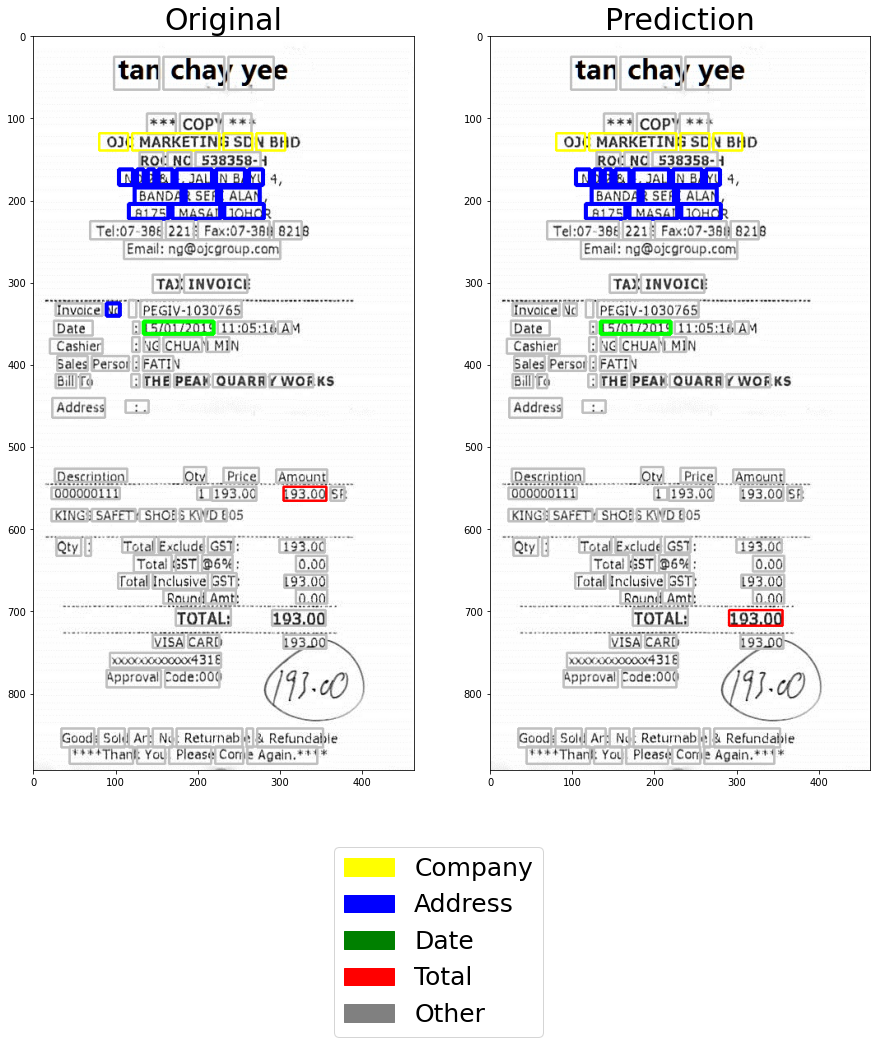

In [ ]:
display_prediction(merged_groups[0], 'test')

Filename: X51005444046.jpg


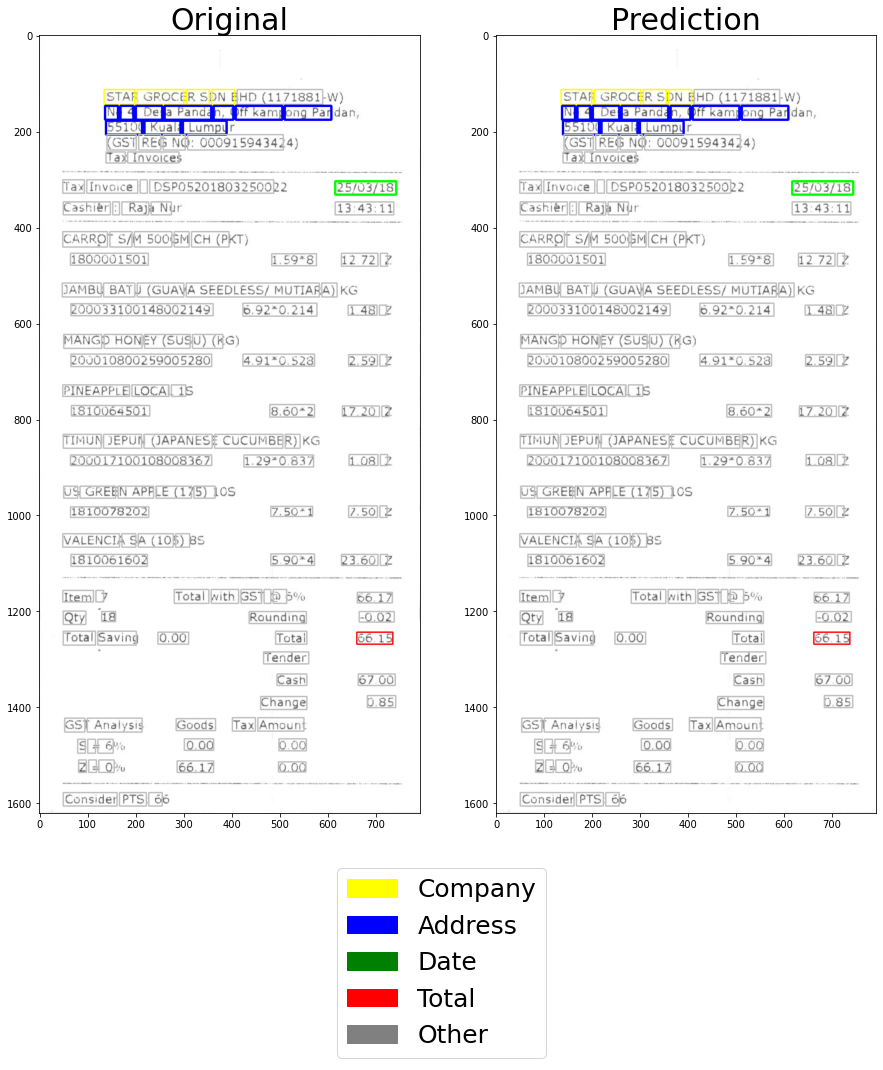

In [ ]:
display_prediction(merged_groups[34], 'test')